# preproc

In [2]:
import numpy as np
from helpers import make_data

In [3]:
def preprocess_image(img):
    return np.where(img >= 0.8, img, 0.0)

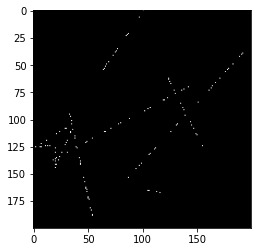

In [4]:
import matplotlib.pyplot as plt
plt.imshow(preprocess_image(make_data(8)[0]), cmap="gray")

# train

In [5]:
!mkdir -p logs

In [6]:
import numpy as np
from helpers import make_data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    BatchNormalization,
    Activation,
    Reshape,
    Flatten,
    Dense,
    Dropout,
)

def gen_model():
    IMAGE_SIZE = 200
    CONV_PARAMS = {"use_bias": False, "padding": "same"}

    model = Sequential()
    model.add(
        Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE))
    )

    for filters, kernel_size in [(8, 11), (16, 9), (32, 7), (64, 5), (128, 3), (256, 3), (512, 3)]:
        model.add(Conv2D(filters, kernel_size=kernel_size, **CONV_PARAMS))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPool2D())
        # model.add(Dropout(0.25))
    
    model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(5))
    return model


def make_batch(batch_size):
    # this model can only train on data where a spaceship is guaranteed, this is not true when testing
    imgs, labels = zip(*[make_data(has_spaceship=True) for _ in range(batch_size)])
    imgs = [preprocess_image(img) for img in imgs]
    imgs = np.stack(imgs)
    labels = np.stack(labels)
    return imgs, labels


from helpers import score_iou
class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.mean_iou = []
        self.score = []
        self.loss = []

    def on_epoch_end(self, epoch, logs={}):
        images, labels = self.model.validation_data
        preds = np.asarray(self.model.predict(images))
        ious = np.array([score_iou(pred, label) for pred, label in zip(preds, labels)])
        self.mean_iou.append(ious.mean())
        self.score.append((ious > 0.7).mean())
        self.loss.append(logs["loss"])


def train(batch_size, steps_per_epoch, epochs, n_val_examples=1000):
    model = gen_model()
    model.compile(loss="mse", optimizer=tf.optimizers.Adam(lr=0.001))
    model.summary()
    model.validation_data = make_batch(n_val_examples)
    
    metrics = Metrics()
    model.fit_generator(
        iter(lambda: make_batch(batch_size), None), 
        steps_per_epoch=steps_per_epoch, 
        epochs=epochs, 
        callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs"), metrics]
    )
    model.save("model.hdf5")
    print("Done")
    return model, metrics

In [7]:
# lr = 0.005
model, metrics = train(32, 250, 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 8)       968       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 200, 200, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 16)      6

In [23]:
print()
print("--- done training ---")
print(f"             loss = {metrics.loss[-1]:.3f}")
print(f"         mean_iou = {metrics.mean_iou[-1]:.3f}")
print(f"            score = {metrics.score[-1]:.3f}")
print()
print(f"        best_loss = {min(metrics.loss):.3f}")
print(f"    best_mean_iou = {max(metrics.mean_iou):.3f}")
print(f"       best_score = {max(metrics.score):.3f}")
print()


--- done training ---
             loss = 24.076
         mean_iou = 0.548
            score = 0.085

        best_loss = 20.216
    best_mean_iou = 0.571
       best_score = 0.134



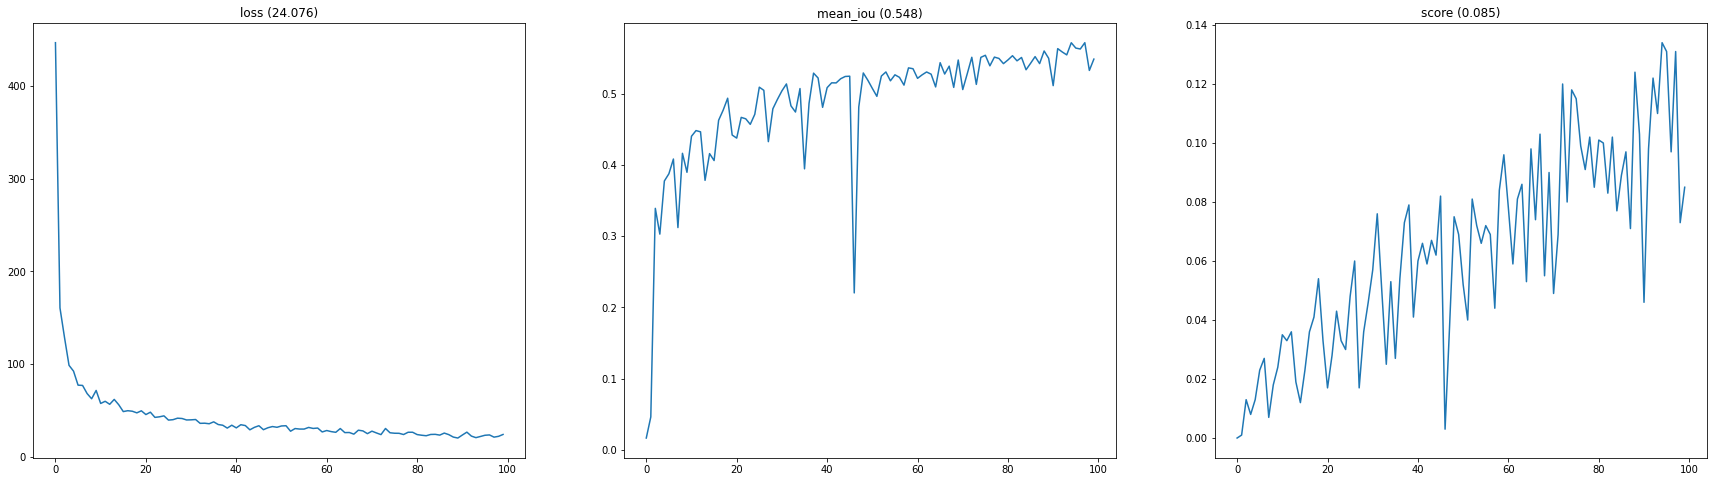

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(30, 8))
t = list(range(100))
ax[0].plot(t, metrics.loss)
ax[0].set_title(f"loss ({metrics.loss[-1]:.3f})")
ax[1].plot(t, metrics.mean_iou)
ax[1].set_title(f"mean_iou ({metrics.mean_iou[-1]:.3f})")
ax[2].plot(t, metrics.score)
ax[2].set_title(f"score ({metrics.score[-1]:.3f})")
plt.show()

In [27]:
for i, l in enumerate(metrics.loss):
    print(i*32*250, "\t", round(l, 2))

0 	 446.86
8000 	 160.61
16000 	 128.79
24000 	 98.69
32000 	 92.38
40000 	 77.28
48000 	 76.98
56000 	 68.23
64000 	 62.6
72000 	 71.57
80000 	 57.55
88000 	 59.87
96000 	 56.62
104000 	 61.9
112000 	 56.13
120000 	 48.77
128000 	 49.7
136000 	 49.14
144000 	 47.39
152000 	 49.6
160000 	 45.55
168000 	 48.1
176000 	 42.51
184000 	 43.11
192000 	 44.14
200000 	 39.57
208000 	 40.02
216000 	 41.63
224000 	 41.29
232000 	 39.71
240000 	 39.85
248000 	 40.19
256000 	 36.07
264000 	 36.22
272000 	 35.64
280000 	 37.69
288000 	 34.79
296000 	 34.02
304000 	 30.96
312000 	 34.04
320000 	 31.18
328000 	 34.59
336000 	 33.67
344000 	 29.09
352000 	 31.73
360000 	 33.49
368000 	 29.22
376000 	 31.33
384000 	 32.61
392000 	 31.82
400000 	 33.24
408000 	 33.48
416000 	 27.57
424000 	 30.44
432000 	 29.91
440000 	 29.89
448000 	 31.66
456000 	 30.57
464000 	 30.99
472000 	 26.77
480000 	 28.32
488000 	 27.14
496000 	 26.4
504000 	 30.46
512000 	 26.08
520000 	 26.18
528000 	 24.41
536000 	 28.68
5

In [ ]:
# [(8, 11), (16, 9), (32, 7), (64, 5), (128, 3), (256, 3), (512, 3)]
# kernel_size = 11, 9, 7, 5, 3, 3, 3
# nfilters = 8, 16, 32, 64, 128, 256, 512
# batch_size = 32
# relu, no dropout, no regularization, simple n_classes dense at the end (no activation on it)
# main() 

# eval = 0.142
# 30 epochs

In [114]:
# kernel_size = 9, padding same, no bias
# nfilters = 8, 16, 32, 64, 128, 256, 512 
# batch_size = 32
# relu, no dropout, no regularization, simple n_classes dense at the end (no activation on it)
# main() 

# eval = 0.036

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_32 (Reshape)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 200, 200, 8)       968       
_________________________________________________________________
batch_normalization_186 (Bat (None, 200, 200, 8)       32        
_________________________________________________________________
activation_186 (Activation)  (None, 200, 200, 8)       0         
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 100, 100, 16)      10368     
_________________________________________________________________
batch_normalization_187 (Bat (None, 100, 100, 16)    

In [110]:
# kernel_size = 9, padding same, no bias
# nfilters = 8, 16, 32, 64, 128, 256, 512 
# batch_size = 32, iters_per_epoch = 1000
# relu, no dropout, no regularization, simple n_classes dense at the end (no activation on it)
# main() 

# eval = 0.02

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 200, 200, 8)       648       
_________________________________________________________________
batch_normalization_179 (Bat (None, 200, 200, 8)       32        
_________________________________________________________________
activation_179 (Activation)  (None, 200, 200, 8)       0         
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 100, 100, 16)      10368     
_________________________________________________________________
batch_normalization_180 (Bat (None, 100, 100, 16)    

In [7]:
# default with preprocessing of image
# main()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 8)       72        
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 200, 200, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 16)      6

# eval

In [28]:
from helpers import make_data, score_iou
import numpy as np
from tensorflow import keras
from tqdm import tqdm


def eval():
    model = keras.models.load_model("model.hdf5")

    ious = []
    images, labels = make_batch(1000)
    for img, label in tqdm(zip(images, labels), total=1000):
        pred = model.predict(img[None])
        pred = np.squeeze(pred)
        ious.append(score_iou(label, pred))

    ious = np.asarray(ious, dtype="float")
    ious = ious[~np.isnan(ious)]  # remove true negatives
    print()
    print((ious > 0.7).mean())
    # 0.004

In [29]:
eval()

100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]


0.131
